In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")


In [3]:
trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

trades.head()


/tmp/ipython-input-458823452.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("/content/historical_data.csv")


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
trades.info()
sentiment.head()
sentiment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93186 entries, 0 to 93185
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           93186 non-null  object 
 1   Coin              93186 non-null  object 
 2   Execution Price   93186 non-null  float64
 3   Size Tokens       93186 non-null  float64
 4   Size USD          93186 non-null  float64
 5   Side              93186 non-null  object 
 6   Timestamp IST     93186 non-null  object 
 7   Start Position    93186 non-null  float64
 8   Direction         93186 non-null  object 
 9   Closed PnL        93186 non-null  float64
 10  Transaction Hash  93185 non-null  object 
 11  Order ID          93185 non-null  float64
 12  Crossed           93185 non-null  object 
 13  Fee               93185 non-null  float64
 14  Trade ID          93185 non-null  float64
 15  Timestamp         93185 non-null  float64
dtypes: float64(9), object(7)
memory usage: 1

In [7]:
trades['Timestamp'] = pd.to_numeric(trades['Timestamp'], errors='coerce')
trades['time'] = pd.to_datetime(trades['Timestamp'], unit='ms')

trades['date'] = trades['time'].dt.date

In [8]:
# Converts sentiment date column to proper date object
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date

# Keeps only the needed columns
sentiment_simple = sentiment[['date', 'classification']].rename(
    columns={'classification': 'sentiment'}
)

sentiment_simple.head()


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [9]:
daily_stats = trades.groupby('date').agg({
    'Closed PnL': ['sum', 'mean'],
    'Size USD': 'sum'
})

# rename columns
daily_stats.columns = ['pnl_sum', 'pnl_mean', 'volume_sum']

# reset index to flatten
daily_stats = daily_stats.reset_index()

daily_stats.head()


,date,pnl_sum,pnl_mean,volume_sum
0,2023-03-28,0.000000e+00,0.000000,477.00
1,2023-11-14,1.555034e+02,0.148807,11555429.76
2,2024-03-09,1.769655e+05,25.418772,39406770.25
3,2024-07-03,1.823740e+05,55.483432,18562926.91
4,2024-10-27,1.700610e+06,162.753421,56860186.33


In [10]:
daily_merged = daily_stats.merge(sentiment_simple, on='date', how='left')

daily_merged.head()
daily_merged['sentiment'].value_counts()


,count
sentiment,
Greed,3
Extreme Greed,1
Neutral,1
Fear,1


In [11]:
def simplify_sentiment(x):
    if x in ["Greed", "Extreme Greed"]:
        return "Greed"
    elif x == "Fear":
        return "Fear"
    else:
        return "Neutral"

daily_merged['sentiment_simple'] = daily_merged['sentiment'].apply(simplify_sentiment)

daily_merged['sentiment_simple'].value_counts()


,count
sentiment_simple,
Greed,4
Neutral,2
Fear,1


In [12]:
sentiment_group = daily_merged.groupby('sentiment_simple').agg({
    'pnl_mean': ['mean', 'median'],
    'pnl_sum': 'mean',
    'volume_sum': 'mean'
})

sentiment_group


pnl_mean                  pnl_sum    volume_sum
                       mean     median          mean          mean
sentiment_simple                                                  
Fear              82.380151  82.380151  4.905408e+06  4.231146e+08
Greed             47.080250  12.783790  4.694329e+05  2.695572e+07
Neutral           53.806450  53.806450  4.011749e+05  1.427412e+08

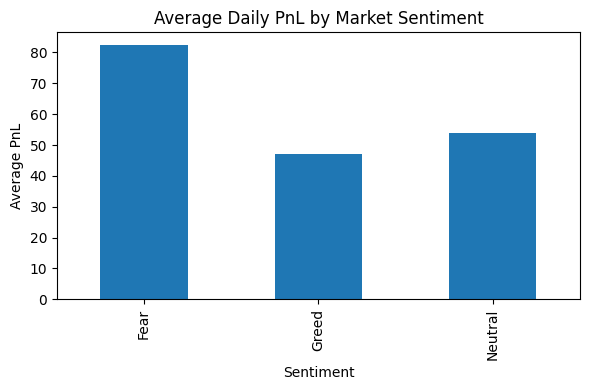

In [13]:
import matplotlib.pyplot as plt

avg_pnl = daily_merged.groupby('sentiment_simple')['pnl_mean'].mean()

plt.figure(figsize=(6,4))
avg_pnl.plot(kind='bar')
plt.title("Average Daily PnL by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.savefig("avg_pnl_by_sentiment.png")
plt.show()


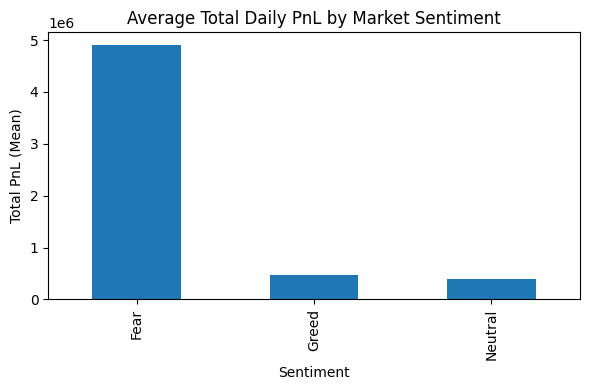

In [14]:
total_pnl = daily_merged.groupby('sentiment_simple')['pnl_sum'].mean()

plt.figure(figsize=(6,4))
total_pnl.plot(kind='bar')
plt.title("Average Total Daily PnL by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Total PnL (Mean)")
plt.tight_layout()
plt.savefig("total_pnl_by_sentiment.png")
plt.show()


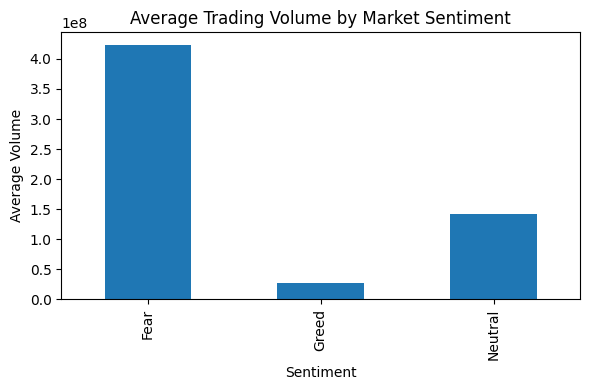

In [15]:
avg_volume = daily_merged.groupby('sentiment_simple')['volume_sum'].mean()

plt.figure(figsize=(6,4))
avg_volume.plot(kind='bar')
plt.title("Average Trading Volume by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Volume")
plt.tight_layout()
plt.savefig("avg_volume_by_sentiment.png")
plt.show()
